## はじめに
以前，2つの時系列データの距離的なものを測るアルゴリズムであるDTWについて，以下のようなものを書きました．

[http://ksknw.hatenablog.com/entry/2017/03/26/234048?_ga=2.165686654.1928884398.1577406641-1114398809.1546042789:embed:cite]

DTWはいい感じのアルゴリズムですが，時系列データの全体と全体を対応付けるので，短いパターンを長い時系列データの中から見つけるみたいなタスクに直接用いることはできません(やろうと思えばできるけど計算量やばい)．
なんかもっといいやつないかなと思っていたところに，たまたま読んだ論文で使われていたSPRINGというアルゴリズムを知ったので，ここでは実装しつつちゃんと理解してみることにしました．
以下ではpythonを使ってSPRINGを実装します．このノートブックの全体は以下にあります．





## 目的
ここでは，時系列データ$X$からある時系列パターン$Y$と似ている区間を見つける問題について考えます．
例として，以下の図に示すような時系列データ$X$ (青線)と時系列パターン$Y$(オレンジ線)を考えます．
ちなみにこれは気象庁で[配布されている](https://www.data.jma.go.jp/gmd/risk/obsdl/)名古屋の気温データです．

ここでの目的は以下のような部分時系列(緑部分)を時系列データ$X$から検出することです．

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from tslearn.metrics import dtw_path

In [2]:
data = pd.read_csv("./data.csv", header=None)[1].values

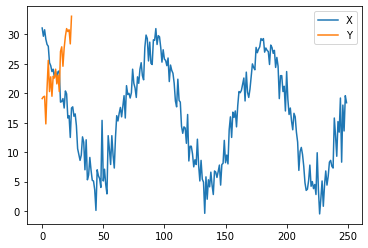

In [3]:
X = data[:1000:4]
Y = data[1000::4]

plt.plot(X, label="X")
plt.plot(Y, label="Y")
plt.legend()
plt.show()

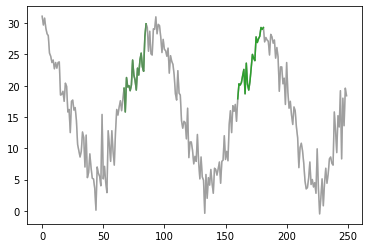

In [4]:
from spring import spring
for path, cost in spring(X, Y, 80):
    plt.plot(X, c="gray", alpha=0.5)
    plt.plot(path[:,0], X[path[:,0]], C="C2")

2つの時系列データの距離(のようなもの)を測る方法の1つとして，Dynamic Time Warping (DTW)があります．
DTWについて詳しくは前[書いたやつを参照](http://ksknw.hatenablog.com/entry/2017/03/26/234048?_ga=2.173474403.1928884398.1577406641-1114398809.1546042789)．
しかし，DTWは2つの時系列データ全体同士を比較するものなので，これを今回の目的にそのまま用いることはできません．
時系列データの部分一致の問題を扱うアルゴリズムの1つとして，[SPRING](https://pdfs.semanticscholar.org/794e/d5f86c5ad30564def57b5425d3ea08b10be4.pdf)があります．
以下では，DTWについて簡単に説明したあと，部分一致DTW，そして，SPRINGについて説明します．


## DTWと動的計画法

DTWでは2つの時系列データ$X = [X^{(1)}, \dots, X^{(T_x)}]$と時系列データ$Y = [Y^{(1)}, \dots, Y^{(T_y)}]$の距離的なもの(以下ではDTW距離)を求めます．
DTWでは2つの時系列データに含まれる各フレーム$X_i, Y_j$を，フレーム間の距離の総和が最小になるように対応付けを求めます．
このときの，フレーム間の距離の総和がDTW距離です．

ここではフレーム間の距離として二乗距離を考えます．
各フレーム間の距離を並べた行列$\Delta$, $\Delta_{i,j} = \|X^{(i)} - Y^{(j)} \|_2^2$は以下のようなものです．

以下では，説明のために，一旦同じぐらいの長さの時系列データ$X,Y$を考えます．

In [5]:
X = data[280:400:4]
Y = data[1000::4]

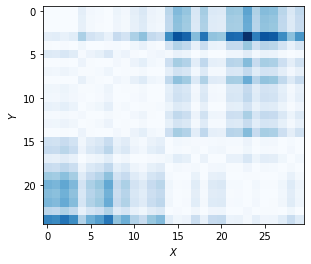

In [6]:
D = (np.array(X).reshape(1, -1) - np.array(Y).reshape(-1, 1))**2
plt.imshow(D, cmap="Blues")
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.show()

次にDTWではフレーム間の対応付(アライメント)を求めます．
実際に求まるアライメントを以下の図に示します．

In [7]:
path, dtw_dist = dtw_path(X, Y)

In [8]:
def plot_path(paths, A, B, D):
    plt.figure(figsize=(5,5))
    gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,5],
                       height_ratios=[5,1]
                       )
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax4 = plt.subplot(gs[3])

    ax2.pcolor(D, cmap=plt.cm.Blues)
    ax2.get_xaxis().set_ticks([])
    ax2.get_yaxis().set_ticks([])
    
    for path in paths:
        ax2.plot(path[:,0]+0.5, path[:,1]+0.5, c="C3")
    
    ax4.plot(A)
    ax4.set_xlabel("$X$")
    ax1.invert_xaxis()
    ax1.plot(B, range(len(B)), c="C1")
    ax1.set_ylabel("$Y$")

    ax2.set_xlim(0, len(A))
    ax2.set_ylim(0, len(B))
    plt.show()

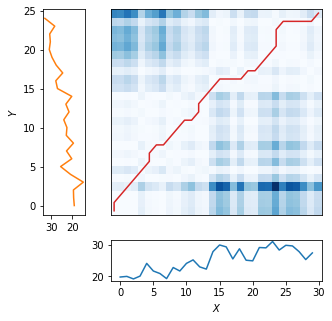

In [9]:
plot_path([np.array(path)], X, Y, D)

図の中で，青線，オレンジ線はそれぞれ$X$, $Y$を表しています．
右上の図の青色は$Delta$を表しており，1本の赤線(パス)で表したものがアライメントされたフレームを表します．
ここで，アライメントは以下の3つの制約条件を満たすもののなかで，パス上のコストが最小になるものです．

- 境界条件: 両端が左下と右上にあること
- 単調性: 左下から始まり，→，↑，➚のいずれかにしか進まないこと
- 連続性: 繋がっていること

フレームの対応付けを図に書くと以下です．
境界条件は$X,Y$の両端のフレームを対応付けること，単調性は対応づけがクロスしないこと，連続条件は対応付けられないフレームが存在しないことを表しています．

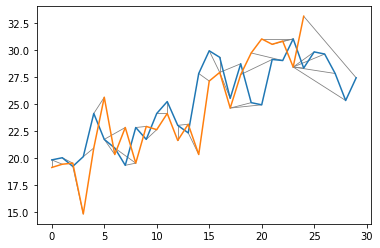

In [10]:
for line in path:
    plt.plot(line, [X[line[0]], Y[line[1]]], linewidth=0.8, c="gray")
plt.plot(X)
plt.plot(Y)
plt.show()

DTWではこれらの制約条件を満たすパスの集合$\mathcal A$のうち，パス上の距離$\Delta$の総和が最小となるパスを求めるアルゴリズムです．
式で書くと以下です．
$$\min_{A \in \mathcal A} \big < A, \Delta \big >$$
ただし，$\big < \cdot, \cdot \big >$は行列の内積を意味します．

この最適化問題は動的計画法を使って解くことができます．
つまり，左下のマスからスタートして，各マスに到達するため最小の累積コストを1マスずつ求めます．
このとき，→，↑，➚のいずれかにしか移動できないので，$i+1, j+1$マスの最小の累積和$C$は
$$C_{i,j} = \min \big(C_{i, j+1}, C_{i+1, j}, C_{i+1, j+1} \big)$$
で求めることができます．
ただし，左下のマス($i=1, j=1$)では，$C_{1,1}=\Delta_{1,1}$であり，下一列($i\neq 1, j=1$)のときは，
$$C_{i+1, 1} = C_{i, 1} + \Delta_{i+1, 1}$$
です．
また，左一列も同様にして
$$C_{i, j+1} = C_{1, j} + \Delta_{1, j+1}$$
です．

累積コストを求めるときに使ったマス($\mathrm{argmin} (C_{i, j+1}, C_{i+1, j}, C_{i+1, j+1})$)を記録しておくことで，終端(右上)にたどり着いた時，この記録を逆にたどることで，累積コストを最小にするパスを求めることができます．

DTWを用いることで，時系列データ間の類似度を求めることができますが，今回のタスクに直接用いることはできません．
実際にやってみると以下のようなパス，アライメントが得られます．

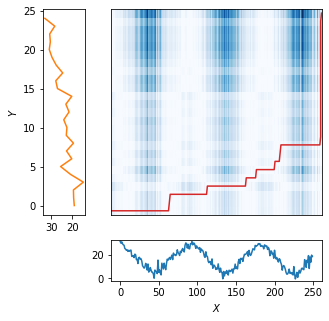

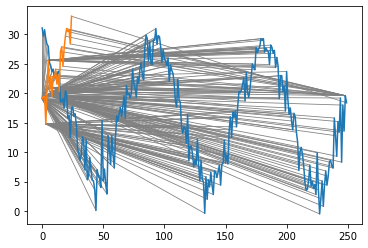

In [11]:
X = data[:1000:4]
Y = data[1000::4]

D = (np.array(X).reshape(1, -1) - np.array(Y).reshape(-1, 1))**2
path, dtw_dist = dtw_path(X, Y)
plot_path([np.array(path)], X, Y, D)

for line in path:
    plt.plot(line, [X[line[0]], Y[line[1]]], linewidth=0.8, c="gray")
plt.plot(X)
plt.plot(Y)
plt.show()

むりやり全体と全体を対応付けようとするため，よくわからない感じになっています．

## 部分一致DTW

次に，時系列データ$X=[X^{(1)}, \dots, X^{(T_x)}]$から，時系列パターン$Y = [Y^{(1)}, \dots, Y^{(T_y)}], (T_x > T_y)$に，最もDTW距離が近い区間を1箇所見つける問題を考えます．
ナイーブな方法として，ありうる全ての部分時系列$[X^{(t)},...,X^{(s)}]$とパターン$Y$とのDTW距離を求め，最も小さいDTW距離をもつ区間を検出する方法が考えられます．
しかし，この方法は時系列データ$X$の長さが長くなると計算量が大きくなってしまいます．

SPRINGでは，DTWの動的計画法を一部修正することによって，部分一致問題を解くことを提案しています．
(以下では[文献](https://pdfs.semanticscholar.org/794e/d5f86c5ad30564def57b5425d3ea08b10be4.pdf)とは若干異なるアルゴリズムを説明しますが，たぶんやっていることは同じです．これは自分的実装の楽さから変更されています．)
以下ではこのアルゴリズムを部分一致DTWと呼びます．

DTWの境界条件を以下のように変更することで，部分一致問題に対応することができます．

- 境界条件: 下の一列のどこかのマスと上の一列のどこかのマスを通る

これは$Y$の両端が$X$のいずれかのフレームと対応付けられることを意味します．
一方で，$X$の両端のフレームは必ずしも対応付けられる必要はありません．

アルゴリズムとしては，動的計画法の中で以下の2点を変更します．
- 下一列($i\neq 1, j=1$)の累積コストを$C_{i+1, 1} = C_{i, 1} + \Delta_{i+1, 1}$から$C_{i+1, 1} = \Delta_{i+1, 1}$に変更
- 終了地点を右上のマスから，$\mathrm{argmin}_i (C_{i, T_y})$へと変更

これらの変更はそれぞれ，始点と終点の変更に対応します．
これらの変更によって得られたパスを以下の図に示します．

In [12]:
X = data[:1000:4]
Y = data[1000::4]

In [13]:
def dist(x, y):
    return (x - y)**2

def get_min(m0, m1, m2, i, j):
    if m0 < m1:
        if m0 < m2:
            return i - 1, j, m0
        else:
            return i - 1, j - 1, m2
    else:
        if m1 < m2:
            return i, j - 1, m1
        else:
            return i - 1, j - 1, m2

def partial_dtw(x, y):
    Tx = len(x)
    Ty = len(y)

    C = np.zeros((Tx, Ty))
    B = np.zeros((Tx, Ty, 2), int)

    C[0, 0] = dist(x[0], y[0])
    for i in range(Tx):
        C[i, 0] = dist(x[i], y[0])
        B[i, 0] = [0, 0]

    for j in range(1, Ty):
        C[0, j] = C[0, j - 1] + dist(x[0], y[j])
        B[0, j] = [0, j - 1]

    for i in range(1, Tx):
        for j in range(1, Ty):
            pi, pj, m = get_min(C[i - 1, j],
                                C[i, j - 1],
                                C[i - 1, j - 1],
                                i, j)
            C[i, j] = dist(x[i], y[j]) + m
            B[i, j] = [pi, pj]
    t_end = np.argmin(C[:,-1])
    cost = C[t_end, -1]
    
    path = [[t_end, Ty - 1]]
    i = t_end
    j = Ty - 1

    while (B[i, j][0] != 0 or B[i, j][1] != 0):
        path.append(B[i, j])
        i, j = B[i, j].astype(int)
        
    return np.array(path), cost


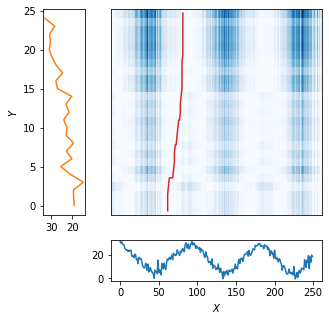

In [14]:
path, cost = partial_dtw(X, Y)
D = (np.array(X).reshape(1, -1) - np.array(Y).reshape(-1, 1))**2
plot_path([np.array(path)], X, Y, D)

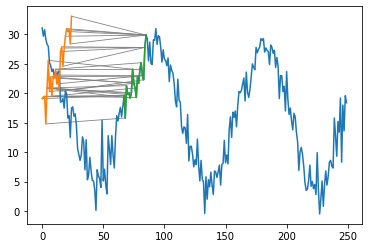

In [15]:
for line in path:
    plt.plot(line, [X[line[0]], Y[line[1]]], linewidth=0.8, c="gray")
plt.plot(X)
plt.plot(Y)
plt.plot(path[:,0], X[path[:,0]], c="C2")
plt.show()

$X$から$Y$と似た部分時系列が一部のみ抽出されていることがわかります．


## 複数の区間の検出

上で説明した手法を用いることで，長い時系列データ$X$から時系列パターン$Y$に一致する部分時系列を抜き出すことができました．
一方で，この方法では最もDTW距離が小さい1つの区間しか検出することができませんでした．
SPRINGでは，$X$の中からパターン$Y$とDTW距離が$\epsilon$以下の部分時系列を複数検出することを提案しています．
**SPRINGでは特にオンライン設定を対象としており，ここでも同様に$X$が徐々に観測されていくときを考えます．**


このとき，DTW距離が$\epsilon$以下の部分時系列の区間が重複している場合が考えられます．
このような場合に，全ての区間を列挙することもできますが，可視化などの応用を考えると，全ての区間を検出することは適切ではなさそうです．
SPRINGでは重複する区間を全て列挙するのではなく，重複するもののうち，最もDTW距離が小さいもの1つを検出します．

SPRINGでは，この問題を扱うために，各マスについて区間の開始地点を記録，伝搬することを提案しています．
つまり，各マスを通る最小コストのパスの区間の開始地点$S_{ij}$をそれぞれのマスで記録します．
これは動的計画法の中で，以下のように埋めることができます．
$S_{i,1}=i$
$S_{i,j} = S_{i^*, j^*}, (i^*, j^*) = \mathrm{argmin}(C_{i,j+1}, C_{i+1,j}, C_{i,j})$

この操作によって，$S_{i,T_y}$には，$(i, T_y)$を通るコスト最小のパスの開始位置が記録された状態になります．
この$S$を用いることで，以下の手順でDTW距離がしきい値$\epsilon$以下の区間を検出することができます．
さらに，ここがよく出来ているところですが，SPRINGでは区間を検出するとき，今後観測される$X$に検出した区間と重複し，かつ，DTW距離が検出した区間よりも小さい区間が存在しないことを保証することができます．

- 現在の時刻を$t$とします．つまり，$X^{(1)},...,X^{(t)}$と$Y$(全区間)が観測されているとします．
- 時刻$t$においてDTW距離が最も小さい区間の終了位置を$i^*$，DTW距離を$d_{min}$とします．この区間を候補と呼びます．

このとき，現在の観測時刻$t$において以下が成り立つなら，現在の候補を検出結果として出力します．

全ての$j = 1,...,T_y$について
$C_{t, j} \geq d_{min}$ または，$S_{t, j} \geq i^*$

これを図にすると以下です(突然の手書き図)．
今，$t=5$で，$C_{1,T_y}$から$C_{t,T_y}$をチェックして，候補(赤線)が見つかったとします．
このとき，SPRINGでは現在の時刻($t$)を通るパス(青や緑)について考えます．
ここで，$t=6$以降はまだ観測していないので，これらのパスもDTW距離も計算することができないことに注意してください．

まず，緑色のパスは赤色の候補と区間が重複していないため，候補を検出するか否かを考える際に，考慮する必要がありません．
$S_{t, j} \geq i^*$を満たすパスがこのパスに相当します．

次に青色のパスについて考えます．
青色のパスは候補と区間が重複しているため，もし青色のパスのほうがDTW距離が小さい場合は赤色の候補を検出してはいけません．
これを判定する基準として，SPRINGでは$C_{t, j}$を用います．
DTWでは正のフレーム間コストを考えるので，そのパスが高さ方向$j$の時点で$C_{t, j}$が$d_{min}$を超えた場合は，現在の候補よりも青色のパスのほうが必ずDTW距離が大きくなることがわかるからです．

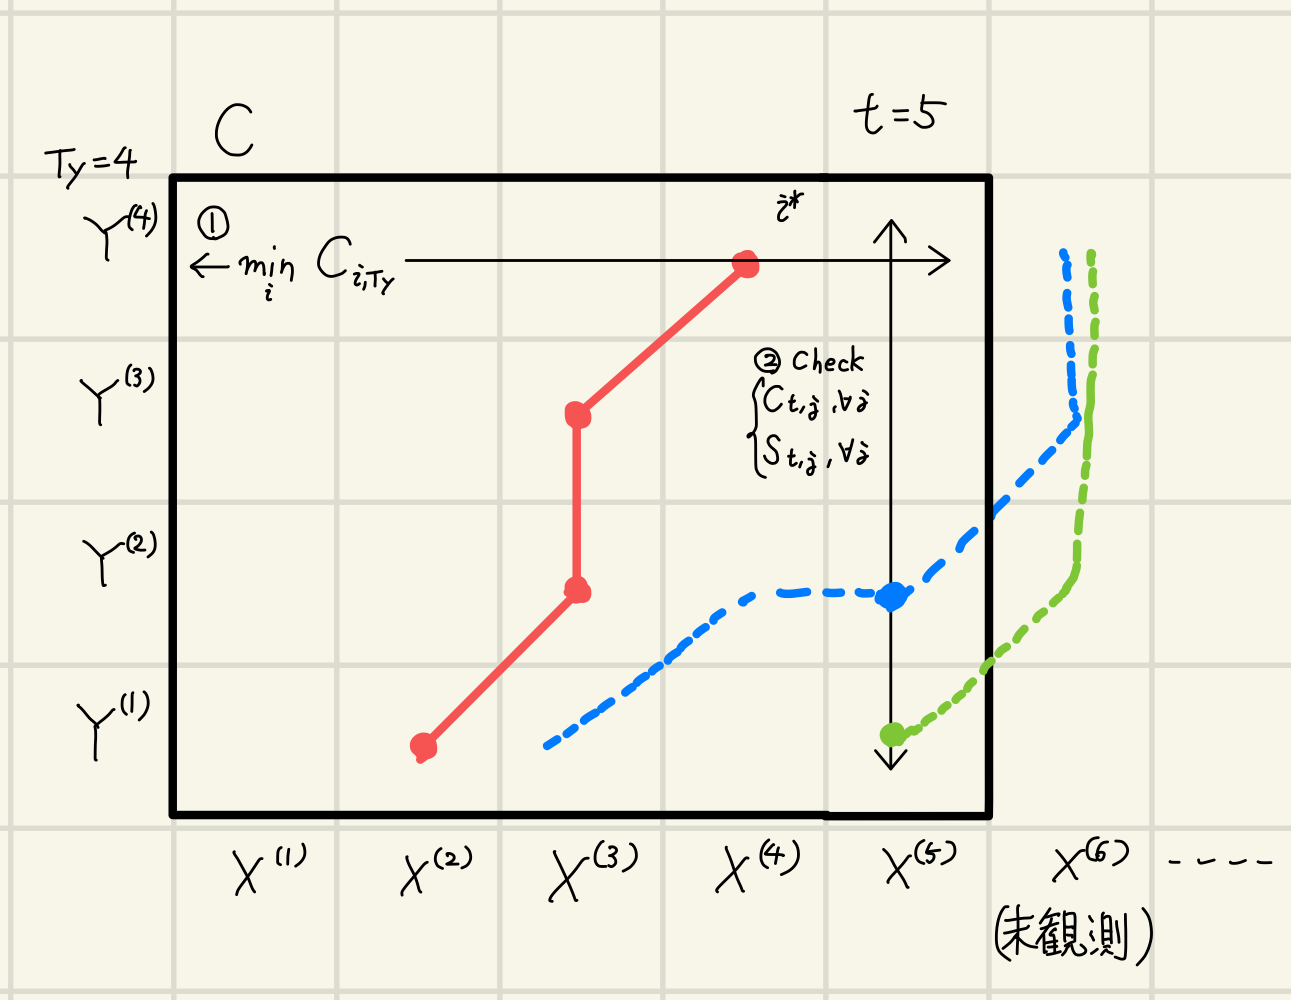

実際にSPRINGによって複数の区間を検出した結果を以下に示します．

In [16]:
def spring(x, y, epsilon):
    Tx = len(x)
    Ty = len(y)

    C = np.zeros((Tx, Ty))
    B = np.zeros((Tx, Ty, 2), int)
    S = np.zeros((Tx, Ty), int)

    C[0, 0] = dist(x[0], y[0])

    for j in range(1, Ty):
        C[0, j] = C[0, j - 1] + dist(x[0], y[j])
        B[0, j] = [0, j - 1]
        S[0, j] = S[0, j - 1]
        
    for i in range(1, Tx):
        C[i, 0] = dist(x[i], y[0])
        B[i, 0] = [0, 0]
        S[i, 0] = i
        
        for j in range(1, Ty):
            pi, pj, m = get_min(C[i - 1, j],
                                C[i, j - 1],
                                C[i - 1, j - 1],
                                i, j)
            C[i, j] = dist(x[i], y[j]) + m
            B[i, j] = [pi, pj]
            S[i, j] = S[pi, pj]
            
        imin = np.argmin(C[:(i+1), -1])
        dmin = C[imin, -1]
        
        if dmin > epsilon:
            continue
            
        for j in range(1, Ty):
            if (C[i,j] < dmin) and (S[i, j] < imin):
                break
        else:
            path = [[imin, Ty - 1]]
            temp_i = imin
            temp_j = Ty - 1
            
            while (B[temp_i, temp_j][0] != 0 or B[temp_i, temp_j][1] != 0):
                path.append(B[temp_i, temp_j])
                temp_i, temp_j = B[temp_i, temp_j].astype(int)
                
            C[S[:,-1] <= imin, -1] = 100000000
            yield np.array(path), dmin

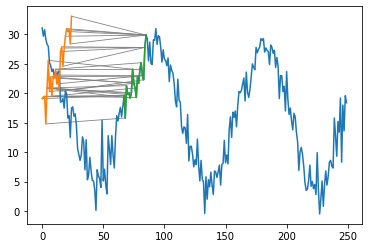

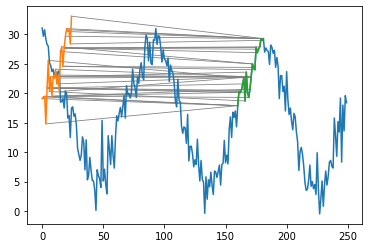

In [17]:
pathes = []
for path, cost in spring(X, Y, 80):
    for line in path:
        plt.plot(line, [X[line[0]], Y[line[1]]], linewidth=0.8, c="gray")
    plt.plot(X)
    plt.plot(Y)
    plt.plot(path[:,0], X[path[:,0]], C="C2")
    plt.show()
    pathes.append(path)

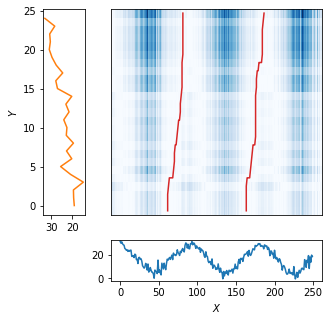

In [18]:
path, cost = partial_dtw(X, Y)
D = (np.array(X).reshape(1, -1) - np.array(Y).reshape(-1, 1))**2
plot_path(pathes, X, Y, D)

## まとめ

ここでは，時系列データから特定の時系列パターンに一致した区間を検出する問題について考え，これを解くアルゴリズムの1つであるSPRINGをpythonで実装しました．
部分一致DTWは応用先の広いアルゴリズムで，最近ではDTWNet(ニューラルネットワークconvolutionカーネルの代わりにDTWを使う)に使われていました．
今回はpythonで実装したので遅いです．せっかくのオンライン設定用のアルゴリズムなので，気が向いたらjitとかjuliaとか使って高速化したいです(C++は嫌だけど)．


## 参考

- [ダイナミックタイムワーピング距離に基づくストリーム処理](https://pdfs.semanticscholar.org/794e/d5f86c5ad30564def57b5425d3ea08b10be4.pdf)
- [Stream Monitoring under the Time Warping Distance](https://www.cs.cmu.edu/~christos/PUBLICATIONS/ICDE07-spring.pdf)
- [気象庁|過去の気象データ・ダウンロード](https://www.data.jma.go.jp/gmd/risk/obsdl/)
- [DTW (動的時間伸縮法)の実装](http://ksknw.hatenablog.com/entry/2017/03/26/234048)
- [DTWNet: a Dynamic Time Warping Network](https://papers.nips.cc/paper/9338-dtwnet-a-dynamic-time-warping-network)